# Introduction to neural networks

The most basic neural nework is called a **multi-layered perception**. It is a neural network where the neurons in each layer are connected to **all** the neurons in the next layer. For this reason we call it a **dense** network.

In this notebook we use `numpy` to manually create and train a neural network. We do this mostly so we can build some intuition around what happens behind the scene when we train a neural network.

The data we use is manually created. We want to have a very small data set so that we can look at intermediate results as we build our neural network.

In [1]:
import numpy as np

X1 = np.array(np.arange(0.1, 0.7, 0.1))
X1 = np.exp(X1 * 1.1 + 0.75)
X2 = np.array(np.arange(0.6, 1.2, 0.1))
X2 = np.exp(X2 * 0.4 + 0.75)
X3 = np.random.random(6)
X3 = np.exp(X3 * 0.4 + 0.75)

X_train = np.array([X1, X2, X3]).T
y_train = (X_train[:,:1] > 3).all(axis = 1).reshape(6, 1)

print(np.hstack([X_train, y_train]))
del X1, X2, X3

[[2.36316069 2.69123447 2.28048338 0.        ]
 [2.63794446 2.80106583 2.30785847 0.        ]
 [2.94467955 2.9153795  2.78684981 0.        ]
 [3.28708121 3.03435839 2.24727165 1.        ]
 [3.66929667 3.15819291 2.6288331  1.        ]
 [4.0959554  3.28708121 2.59822377 1.        ]]


## Using a logistic regression

Before we train a neural network, it might be worthwhile asking what we would do if we had to solve this using the tools we already have at our disposal. Since our target is binary, using a `LogisticRegression` is one easy option. So let's try it:

In [2]:
from sklearn.linear_model import LogisticRegression

logmod = LogisticRegression()
logmod.fit(X_train, y_train.ravel())
y_hat = logmod.predict(X_train)

Let's evaluate our model. Usually we would evaluate the model on the training data. We'll worry about a test data later. For now that's besides the point.

In [3]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_hat)

array([[3, 0],
       [0, 3]])

So with logistic regression, we can train a model that seems to quickly find the decision boundary. How does logistic regression make its prediction? It uses the following formula to get raw predictions .

$$\text{raw_predictions} = b_0 + b_1x_1 + b_2x_2 + b_3x_3$$

In previous lectures, we referred to $b_0$, $b_1$ and $b_2$ as the model's **parameters**: $b_0$ is called the **intercept** and $b_1$, $b_2$ and $b_3$ are called **coefficients**. These raw predictions represent our confidence about how likely it is that any row of the data would belong to the positive class. But the scale of the these raw predictions are somewhat arbitrary.

In [4]:
print("Model intercept (bias): ")
print(logmod.intercept_)
print("Model coefficients (weights): ")
print(logmod.coef_.T)

pred = logmod.intercept_ + np.dot(X_train, logmod.coef_.T)
pred

Model intercept (bias): 
[-4.10737379]
Model coefficients (weights): 
[[ 1.00136357]
 [ 0.34646945]
 [-0.03708446]]


array([[-0.89313073],
       [-0.58093425],
       [-0.25193785],
       [ 0.15216321],
       [ 0.56365473],
       [ 1.03668623]])

Let's see an example of an **activation function**. Here we use the **sigmoid** activation function, also called the **logistic** activation function, given by $\sigma(z) = \frac{1}{1+e^-z}$. It forces the activations to be between 0 and 1. Before passing the input to this function, use use `np.clip` to trim it between -500 and 500.

In [5]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1/(1 + np.exp(-x))

We can take the raw predictions and pass them to a **sigmoid** function and get predictions that are rescaled to be between 0 and 1. We interpret the these scaled predictions as the probability that a given row belongs to the positive class.

In [6]:
np.hstack([sigmoid(pred), y_train])

array([[0.29046418, 0.        ],
       [0.35871765, 0.        ],
       [0.43734659, 0.        ],
       [0.53796757, 1.        ],
       [0.63729775, 1.        ],
       [0.73821011, 1.        ]])

By the way, the the above is is what we obtain when we run the `predict_proba` method of the trained model.

In [7]:
logmod.predict_proba(X_train) # the second column shows the probability of Y = 1

array([[0.70953582, 0.29046418],
       [0.64128235, 0.35871765],
       [0.56265341, 0.43734659],
       [0.46203243, 0.53796757],
       [0.36270225, 0.63729775],
       [0.26178989, 0.73821011]])

Notice that when the prediction is below 0.50 the labels are 0 and otherwise the labels are 1. The reason we started with `LogisticRegression` is because the way that it trains is very similar to a neural network. In fact, a logistic regression model is a neural network with **no hidden layer**. So let's now manually create our neural network and see how we can get a result similar to what `LogisticRegression` obtained above.

## Neural network

Let's return to our prediction equation:

$$\text{raw_predictions} = b_0 + b_1x_1 + b_2x_2 + b_3x_3$$

In neural networks, we prefer to use the word **bias** for the intercept and **weights** for the coefficients. We saw how logistic regression found its parameters. Now we want to see how a neural network find its parameters? It starts with some random values for them. We call this **random initialization**. We usally generate numbers that are random but close to 0.

In [8]:
def init_parameters(dim1, dim2 = 1, std = 1e-1, random = True):
    if(random):
        return(np.random.random([dim1, dim2]) * std)
    else:
        return(np.zeros([dim1, dim2]))

Once we have values for the parameters, we can now run a **forward pass**, which ultimately ends in **predictions**. Of course, because we randomly initialized our parameters, the first time around the predictions are as good as coin cosses.

Note that our forward pass consists of a matrix multiplication, for which we use `np.dot`. The forward pass takes the input data and multiplies it by weights and adds the bias, the result of which is called a **weighted sum**, called `Z1` below. It then applies the **activation function** to the weighted sum, we get the **activations**, called `A1` here. 

In this example, we don't have any hidden layers, so our forward pass will take us directly from the data to the predictions. But if we had hidden layers, we would run this same calculation once for each hidden layers, finally finishing with the prediction.

In [9]:
def forward(W1, bias, X):
    Z1 = np.dot(X, W1) + bias
    A1 = sigmoid(Z1)
    return(A1)

Let's test our function to make sure it works.

In [10]:
_, input_cols = X_train.shape
_, output_cols = y_train.shape

weights = init_parameters(input_cols, output_cols)
bias = init_parameters(output_cols)

print("Checking dimensions: {} * {} + {}".format(X_train.shape, weights.shape, bias.shape))

pred = forward(weights, bias, X_train)
pred

Checking dimensions: (6, 3) * (3, 1) + (1, 1)


array([[0.59019072],
       [0.58810739],
       [0.58865929],
       [0.59481068],
       [0.59143823],
       [0.59889682]])

With the forward pass, we now have a prediction. Our next question is how can we imporve our prediction? The answer is that we need to calculate our error (called **loss**) and from that derive the **derivative of loss w.r.t. weights and biases**. In mulivariate calculus, this derivatite is called the **gradient**.

In previous lectures, we learned that for classification model, we can measure the error by looking at **accuracy** (or precision and recall for imbalanced data). However, as it turns out these metrics are not going to work well here, because in order to get derivatives in calculus we need **continuous functions**, and accuracy, precision or recall are not continuous functions of our weights and biases. Another problem is that these metrics are obtained **after** we define our threshold, and can change if we change our threshold. So we need something else.

One loss function that works well with classification is the **cross-entropy loss**. For binary classification, cross-entropy for the $i$th data point is defined as $y_i*log (\hat y_i) + (1-y_i)*log(1-\hat y_i)$, where $y_i$ is our binary target, and $\hat y_i$ is the prediction (activation at the output layer) at row $i$. Cross-entropy for the whole data is just the average of the cross-entropies at each row.

While we don't show the derivation here, once we define our loss function, we can get the derivative of loss w.r.t. the activations `A1`, and then (using the chain rule) get the derivative of loss w.r.t. to `Z1`, and finally w.r.t. weights and biases.

In [11]:
def backward(A1, W1, bias, X, Y):

    m = np.shape(X)[0] # used the calculate the cost by the number of inputs -1/m
   
    loss = Y * np.log(A1) + (1 - Y)*np.log(1 - A1)           # loss at each row
    cost = (-1/m) * np.sum(loss)                             # loss across all rows
    dZ1 = A1 - Y                                             # derivative of loss wrt Z1
    dW1 = (1/m) * np.dot(X.T, dZ1)                           # derivative of loss wrt weights
    dBias = (1/m) * np.sum(dZ1, axis = 0, keepdims = True) # derivative of loss wrt bias
    
    grads = {"dW1": dW1, "dB1": dBias}                       # updated weights and biases
    
    return(grads, cost)

Let's once again test the output to make sure it's working.

In [12]:
gradients, _ = backward(pred, weights, bias, X_train, y_train)
gradients

{'dW1': array([[0.03426631],
        [0.18559486],
        [0.28497981]]),
 'dB1': array([[0.09201719]])}

We now have all we need to start running our optimazion routine: a simple implementation of **gradient descent**. This cosists of iteratively running forward propagation to get predictions, the backpropagation to get the gradient of loss w.r.t. weights and biases, and finally moving weights and biases in the direction of their gradient. For the latter, we control the size of the step using a constant we call the **learning rate**. As we do this, we record loss at each iteration so that we can plot it and make sure that loss is decreasing at the end of each iteration.

In [13]:
def run_grad_desc(num_epochs, learning_rate, X, Y):
    
    m, input_cols = X.shape
    
    W1 = init_parameters(input_cols, output_cols)
    B1 = init_parameters(output_cols)
    
    loss_array = np.ones([num_epochs])*np.nan     # place-holder of keeping track of loss
    
    for i in np.arange(num_epochs):
        A1 = forward(W1, B1, X)                   # get activations in final layer
        grads, cost = backward(A1, W1, B1, X, Y)  # get gradient and the cost from BP 
        
        W1 = W1 - learning_rate*grads["dW1"]      # update weights
        B1 = B1 - learning_rate*grads["dB1"]      # update bias
        
        loss_array[i] = cost                      # record loss for current iteration
        
        parameter = {"W1": W1, "B1": B1}          # record parameters for current iteration
    
    return(parameter, loss_array)

That's it. Let's now run our gradient descent function for 1000 iterations.

In [24]:
num_epochs = 500
learning_rate = 0.01
params, loss_array = run_grad_desc(num_epochs, learning_rate, X_train, y_train)

After letting the network train for many iterations, these are the final parameters we have.

In [25]:
print(params['B1'][0])
print(params['W1'].ravel())

[-0.15659341]
[ 0.62630549 -0.05607513 -0.60840403]


And these are the parameters we got when we trained a logistic regression model.

In [26]:
print(logmod.intercept_)
print(logmod.coef_)

[-3.72464719]
[[ 0.98755469  0.34155212 -0.16456996]]


We can see that the parameters don't necessarily look similar. This can be a lot of reasons for that. Because our data is close to linearly separable, there are a lot of possible solutions. There could also be differences between the `sklearn` logistic regression and our implementation of neural networks. So instead of comparing the parameters, let's compare the predictions: we can put the predictions we get from using the parameters for the neural network and logistic regression side by side.

In [27]:
Y_pred_nn = params['B1'] + np.dot(X_train, params['W1'])
y_pred_logit = logmod.intercept_ + np.dot(X_train, logmod.coef_.T)

np.hstack([y_pred_logit, Y_pred_nn, y_train])

array([[-0.94705469, -0.58479879,  0.        ],
       [-0.58838584, -0.2347824 ,  0.        ],
       [-0.22225999,  0.04025037,  0.        ],
       [ 0.12351894,  0.12603184,  1.        ],
       [ 0.61533023,  0.62486013,  1.        ],
       [ 1.03998605,  0.73433048,  1.        ]])

Recall that these are raw predictions. So it might be best to pass these to a sigmoid function to turn them nito probabilities.

In [28]:
np.hstack([sigmoid(y_pred_logit), sigmoid(Y_pred_nn), y_train])

array([[0.27947753, 0.35782914, 0.        ],
       [0.3570053 , 0.44157255, 0.        ],
       [0.44466262, 0.51006123, 0.        ],
       [0.53084053, 0.53146632, 1.        ],
       [0.64915574, 0.6513231 , 1.        ],
       [0.73884732, 0.67575485, 1.        ]])

We can see that in either case if we use 0.50 as the cut-off both models predict correctly.

### Exercise

- Run the neural network for 10K iterations insead of 1000 and look at the predictions.
- Run the neural network for 100K iterations insead of 1000 and look at the predictions.
- Do you see a trend?
- Return to where you run `run_grad_desc` and prior to running run the following code: `y_train = np.hstack([y_train, ~y_train])`. Careful! This will break the earlier logistic regression code. Train the network and look at the results that follow. Can you explain what happened? This result has important consequences for our earlier claim that you can do multi-class classification with neural networks using a single model (without resorting to **one-vs-rest** or **one-vs-one** models).

### End of exercise

#### 10K iterations

In [34]:
num_epochs = 10000
params, loss_array = run_grad_desc(num_epochs, learning_rate, X_train, y_train)
Y_pred_nn = params['B1'] + np.dot(X_train, params['W1'])
y_pred_logit = logmod.intercept_ + np.dot(X_train, logmod.coef_.T)

np.hstack([y_pred_logit, Y_pred_nn, y_train])

array([[-0.94705469, -4.03414556,  0.        ],
       [-0.58838584, -2.0002881 ,  0.        ],
       [-0.22225999, -0.36478479,  0.        ],
       [ 0.12351894,  0.24163249,  1.        ],
       [ 0.61533023,  3.15769513,  1.        ],
       [ 1.03998605,  3.94151493,  1.        ]])

#### 100K iterations

In [35]:
num_epochs = 100000
params, loss_array = run_grad_desc(num_epochs, learning_rate, X_train, y_train)
Y_pred_nn = params['B1'] + np.dot(X_train, params['W1'])
y_pred_logit = logmod.intercept_ + np.dot(X_train, logmod.coef_.T)

np.hstack([y_pred_logit, Y_pred_nn, y_train])

array([[-0.94705469, -8.48867312,  0.        ],
       [-0.58838584, -4.58846551,  0.        ],
       [-0.22225999, -1.08896871,  0.        ],
       [ 0.12351894,  1.14276547,  1.        ],
       [ 0.61533023,  6.8255791 ,  1.        ],
       [ 1.03998605,  9.73670505,  1.        ]])

In [36]:
y_train = np.hstack([y_train, ~y_train])
params, loss_array = run_grad_desc(num_epochs, learning_rate, X_train, y_train)
Y_pred_nn = params['B1'] + np.dot(X_train, params['W1'])
np.hstack([sigmoid(Y_pred_nn), y_train])

array([[2.03999890e-04, 9.99793714e-01, 0.00000000e+00, 1.00000000e+00],
       [1.00551724e-02, 9.89937250e-01, 0.00000000e+00, 1.00000000e+00],
       [2.52282993e-01, 7.48471953e-01, 0.00000000e+00, 1.00000000e+00],
       [7.57752563e-01, 2.41542173e-01, 1.00000000e+00, 0.00000000e+00],
       [9.98924224e-01, 1.08852636e-03, 1.00000000e+00, 0.00000000e+00],
       [9.99941038e-01, 5.91085866e-05, 1.00000000e+00, 0.00000000e+00]])

Let's show how loss drops iteration over iteration that we train this. This means that in a real-world scenario, if we let training continue indefinitely, eventually we will reach a point where we begin over-fitting to the training data. So it's important to have a test data set aside that we use for knowing when that happens so we can stop training. This is called **early stopping**.

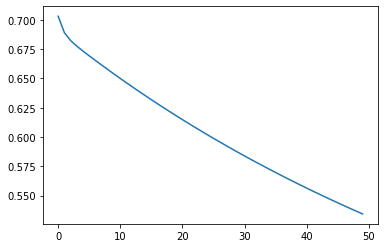

In [33]:
import seaborn as sns

sns.lineplot(data = loss_array[::10]); # we only plot every 50th point so plot renders fast

So we saw how a neural network works. Of course a real neural networks would have at least one hidden layer, but hidden layers only add the amount of computation we have to do. The principle stays the same.